# Import modules

In [17]:
%matplotlib inline
#%matplotlib notebook

#Basic stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# ML models
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import make_scorer

# Regression metrics
from sklearn.metrics import explained_variance_score, median_absolute_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize tqdm progress bar
from tqdm import tqdm, tnrange, tqdm_notebook
from tqdm.auto import tqdm
tqdm.pandas(tqdm_notebook)

In [31]:
%reload_ext autoreload
%autoreload 2
# The averaged random forest model
from AverageRF import AverageRF
from utils import train_test_split_data, evaluate_model

# Functions

In [112]:
def test_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Regression stats
    print(f"Explained Variance Score = {explained_variance_score(y_test,y_pred):.2f}")
    print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_pred):.2f}")
    print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_pred):.2f}")
    print(f"R^2 Score                = {r2_score(y_test, y_pred):.2f}")

# Data

In [3]:
active = pd.read_pickle("./active.pkl.bz2")

In [4]:
active.describe()

,PUBCHEM_SID,Curve Class,Log IC50,IC50,R2
count,8.290000e+02,829.000000,829.000000,829.000000,829.000000
mean,4.170085e+07,1.477443,-4.624427,27.828946,0.974062
std,2.642937e+07,0.475725,0.278188,12.781898,0.026871
min,8.448520e+05,1.100000,-5.650000,2.238721,0.814713
25%,2.478228e+07,1.100000,-4.800000,15.848932,0.966273
50%,2.672420e+07,1.200000,-4.550000,28.183829,0.982946
75%,4.972512e+07,2.100000,-4.400000,39.810717,0.991663
max,1.031636e+08,2.200000,-4.100000,79.432823,0.999892


In [5]:
# Prepare a DataFrame with only the data we need
columns = ['PUBCHEM_SID', 'RDKit Fingerprints', 'Morgan Fingerprints','Log IC50']
data = active.filter(columns,axis=1)
data.reset_index(inplace=True)

In [6]:
X_morgan = np.array(list(data['Morgan Fingerprints'])).astype(int)
y_data = data['Log IC50'].values

## Train - Test split

We will just separate the indices. This is useful if we want to test with different fingerprints.

In [7]:
# This split will return the indices for X, and the y values
X_data = data.index
y_data = data['Log IC50'].values
X_train_index, X_test_index, y_train, y_test = train_test_split(X_data, y_data, test_size=0.10, shuffle=True)

print("X_train:", len(X_train_index), "\t\ty_train:",len(y_train))
print("X_test: ", len(X_test_index), "\t\ty_test: ",len(y_test))
print("-"*36)
print("TOTAL:",len(X_train_index) + len(X_test_index))

X_train: 746 		y_train: 746
X_test:  83 		y_test:  83
------------------------------------
TOTAL: 829


# Morgan Fingerprints

In [9]:
X_train_morgan = np.array(list(data.iloc[X_train_index]['Morgan Fingerprints'])).astype(int)
X_test_morgan  = np.array(list(data.iloc[X_test_index]['Morgan Fingerprints'])).astype(int)
X_train_morgan.shape, y_train.shape

((746, 2048), (746,))

In [27]:
testRF_morgan = RandomForestRegressor(n_estimators=100)
testRF_morgan.fit(X_train_morgan,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [28]:
y_morgan = testRF_morgan.predict(X_test_morgan)

In [30]:
# Regression stats
print("Explained Variance Score =", explained_variance_score(y_test,y_morgan))
print("Mean Absolute Error      =", mean_absolute_error(y_test, y_morgan))
print("Mean SQUARED error       =", mean_squared_error(y_test, y_morgan))
print("MEDIAN ansolute error    =", median_absolute_error(y_test, y_morgan))
print("R^2 Score                =", r2_score(y_test, y_morgan))

Explained Variance Score = -0.007539566748421933
Mean Absolute Error      = 0.16142771084337268
Mean SQUARED error       = 0.05440681626506012
MEDIAN ansolute error    = 0.11750000000000238
R^2 Score                = -0.02711195004315914


# RDKit Fingerprints

In [21]:
X_train_rdkit = np.array(list(data.iloc[X_train_index]['RDKit Fingerprints'])).astype(int)
X_test_rdkit  = np.array(list(data.iloc[X_test_index]['RDKit Fingerprints'])).astype(int)
X_train_rdkit.shape, y_train.shape

((746, 2048), (746,))

In [23]:
testRF_rdkit = RandomForestRegressor(n_estimators=100)
testRF_rdkit.fit(X_train_rdkit,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [24]:
y_rdkit = testRF_rdkit.predict(X_test_rdkit)

In [48]:
# Regression stats
print(f"Explained Variance Score = {explained_variance_score(y_test,y_rdkit):.2f}")
print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_rdkit):.2f}")
print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_rdkit):.2f}")
print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_rdkit):.2f}")
print(f"R^2 Score                = {r2_score(y_test, y_rdkit):.2f}")

Explained Variance Score = 0.25
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.13
R^2 Score                = 0.20


In [66]:
avgRF_test = AverageRF(model_type="regressor",n_forests=5,n_estimators=100, verbosity=1)
avgRF_test.fit(X_train_rdkit,y_train)

SPLIT: 0  [TRAIN: 596 	TEST: 150] 	 Training Time:9.247 seconds.
	  Explained Variance    = 0.3509
	  Mean Absolute Error   = 0.1718
	  Mean Squared Error    = 0.0487
	  Median Absolute Error = 0.1582
	  R^2 Score             = 0.3507 

SPLIT: 1  [TRAIN: 597 	TEST: 149] 	 Training Time:9.145 seconds.
	  Explained Variance    = 0.2893
	  Mean Absolute Error   = 0.1987
	  Mean Squared Error    = 0.0620
	  Median Absolute Error = 0.1670
	  R^2 Score             = 0.2810 

SPLIT: 2  [TRAIN: 597 	TEST: 149] 	 Training Time:9.304 seconds.
	  Explained Variance    = 0.4468
	  Mean Absolute Error   = 0.1668
	  Mean Squared Error    = 0.0429
	  Median Absolute Error = 0.1520
	  R^2 Score             = 0.4038 

SPLIT: 3  [TRAIN: 597 	TEST: 149] 	 Training Time:9.906 seconds.
	  Explained Variance    = 0.3282
	  Mean Absolute Error   = 0.1641
	  Mean Squared Error    = 0.0545
	  Median Absolute Error = 0.1195
	  R^2 Score             = 0.3253 

SPLIT: 4  [TRAIN: 597 	TEST: 149] 	 Training Time:9.

In [67]:
avgRF_test_df = pd.DataFrame(avgRF_test.stats)
avgRF_test_df

,Training Time (s),Explained Variance,Mean Absolute Error,Mean Squared Error,Median Absolute Error,R^2
0,9.247281,0.350902,0.171849,0.048680,0.15825,0.350745
1,9.144572,0.289271,0.198666,0.062024,0.16700,0.280961
2,9.304140,0.446837,0.166818,0.042864,0.15200,0.403803
3,9.905856,0.328216,0.164125,0.054528,0.11950,0.325295
4,9.662188,0.223077,0.198819,0.066142,0.16000,0.206488


In [68]:
y_pred_avgRF = avgRF_test.predict(X_test_rdkit)

In [69]:
# Regression stats
print(f"Explained Variance Score = {explained_variance_score(y_test,y_pred_avgRF):.2f}")
print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_pred_avgRF):.2f}")
print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_pred_avgRF):.2f}")
print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_pred_avgRF):.2f}")
print(f"R^2 Score                = {r2_score(y_test, y_pred_avgRF):.2f}")

Explained Variance Score = 0.20
Mean Absolute Error      = 0.17
Mean SQUARED error       = 0.05
MEDIAN ansolute error    = 0.13
R^2 Score                = 0.14


In [63]:
# Regression stats
print(f"Explained Variance Score = {explained_variance_score(y_test,y_rdkit):.2f}")
print(f"Mean Absolute Error      = {mean_absolute_error(y_test, y_rdkit):.2f}")
print(f"Mean SQUARED error       = {mean_squared_error(y_test, y_rdkit):.2f}")
print(f"MEDIAN ansolute error    = {median_absolute_error(y_test, y_rdkit):.2f}")
print(f"R^2 Score                = {r2_score(y_test, y_rdkit):.2f}")

Explained Variance Score = 0.25
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.13
R^2 Score                = 0.20


In [65]:
y_rdkit

array([-4.5545    , -4.73      , -4.445     , -4.9205    , -4.48275   ,
       -4.4205    , -4.866     , -4.51725   , -4.546     , -4.6685    ,
       -4.49      , -4.703     , -4.893     , -4.5195    , -4.7055    ,
       -4.5585    , -4.4045    , -4.6475    , -4.628     , -4.67      ,
       -4.6635    , -4.75      , -4.422     , -4.7985    , -4.6385    ,
       -4.8825    , -4.562     , -4.789     , -4.5495    , -4.6125    ,
       -4.5665    , -4.522     , -4.522     , -4.796     , -4.8605    ,
       -4.578     , -4.956     , -4.643     , -4.4885    , -4.62      ,
       -4.558     , -4.763     , -4.967     , -4.6485    , -4.5255    ,
       -4.6395    , -4.63      , -4.6585    , -4.706     , -4.729     ,
       -4.7525    , -4.48266667, -4.777     , -4.63      , -4.541     ,
       -4.565     , -4.8495    , -4.4975    , -5.0665    , -4.48575   ,
       -4.5465    , -4.455     , -4.4645    , -4.43883333, -4.758     ,
       -4.775     , -4.493     , -4.5565    , -4.713     , -4.60

In [114]:
from sklearn.ensemble import GradientBoostingRegressor
gboos_reg = GradientBoostingRegressor(n_estimators=250, max_features='sqrt')
test_model(gboos_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.23
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.22


In [115]:
from sklearn.linear_model import SGDRegressor
dgr_reg = SGDRegressor(max_iter=1000, tol=1e-3)
test_model(dgr_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = -846508297461.99
Mean Absolute Error      = 157814.48
Mean SQUARED error       = 44840127319.62
MEDIAN ansolute error    = 106774.01
R^2 Score                = -846508466641.59


In [177]:
from sklearn.linear_model import BayesianRidge
bay_reg = BayesianRidge(n_iter=1000, normalize=True)
test_model(bay_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.27
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.15
R^2 Score                = 0.24


In [127]:
from sklearn.linear_model import ARDRegression
ard_reg = ARDRegression(n_iter=2000)
test_model(ard_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = -1.10
Mean Absolute Error      = 0.24
Mean SQUARED error       = 0.11
MEDIAN ansolute error    = 0.17
R^2 Score                = -1.13


In [176]:
from sklearn.svm import SVR
svr_reg = SVR(kernel="rbf",gamma="scale", epsilon=0.05)
test_model(svr_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.33
Mean Absolute Error      = 0.15
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.31


Text(0.5, 1.0, 'Support Vector Regressor')

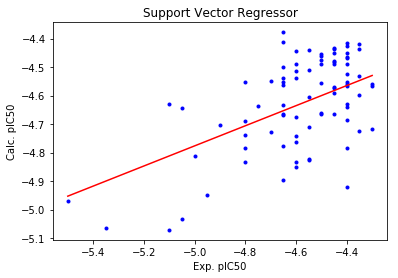

In [215]:
svr_reg.fit(X_train_rdkit, y_train)
y_svr = svr_reg.predict(X_test_rdkit)
fit_fn = np.poly1d(np.polyfit(y_test,rf_pred,1))
fit_lim = [min(y_test),max(y_test)]
plt.plot(y_test,y_svr, "b.",fit_lim,fit_fn(fit_lim),"r")
plt.xlabel("Exp. pIC50")
plt.ylabel("Calc. pIC50")
plt.title("Support Vector Regressor")

In [190]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(bootstrap=False, criterion='mse',
           max_features="sqrt", n_estimators=1000, n_jobs=4, warm_start=False, 
           random_state=42)
test_model(rf_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.24
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.20


In [191]:
rf_reg.fit(X_train_rdkit, y_train)
rf_pred = rf_reg.predict(X_test_rdkit)

Text(0.5, 1.0, 'Random Forest')

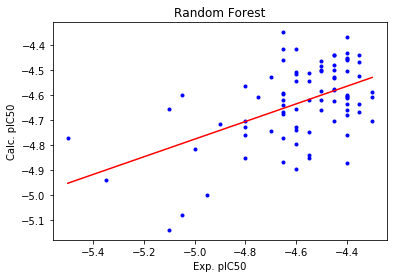

In [214]:
fit_fn = np.poly1d(np.polyfit(y_test,rf_pred,1))
fit_lim = [min(y_test),max(y_test)]
plt.plot(y_test,rf_pred, "b.",fit_lim,fit_fn(fit_lim),"r")
plt.xlabel("Exp. pIC50")
plt.ylabel("Calc. pIC50")
plt.title("Random Forest")

In [155]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=svr_reg, n_estimators=50, loss="linear")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.33
Mean Absolute Error      = 0.15
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.29


In [158]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=svr_reg, n_estimators=50, loss="exponential")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.33
Mean Absolute Error      = 0.15
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.29


In [163]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=rf_reg, n_estimators=50, loss="exponential")
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.26
Mean Absolute Error      = 0.16
Mean SQUARED error       = 0.04
MEDIAN ansolute error    = 0.13
R^2 Score                = 0.21


In [180]:
from sklearn.ensemble import AdaBoostRegressor
adab_reg = AdaBoostRegressor(base_estimator=bay_reg, n_estimators=50, loss="linear", random_state=42)
test_model(adab_reg, X_train_rdkit, y_train, X_test_rdkit, y_test)

Explained Variance Score = 0.11
Mean Absolute Error      = 0.17
Mean SQUARED error       = 0.05
MEDIAN ansolute error    = 0.12
R^2 Score                = 0.08
